In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
import torch
from torch.autograd import Function
from torch import optim
from torch import nn
from torch.nn import functional as F

In [33]:
import dill
with open('/home/quic/QUIC-Projects/saved_model (.pkl)/210316-145500-c2ac705a-e5a2-4470-85f8-07bd52a2387d_qasvm.pkl', 'rb') as f:
    qasvm = dill.load(f)

In [34]:
qasvm.optimizer = None

In [44]:
class TensorQASVM(Function):

    @staticmethod
    def forward(ctx, input, qasvm):
        ctx.qasvm = qasvm
        evaluation = torch.tensor([ctx.qasvm.cost_fn(input.tolist())])
        ctx.save_for_backward(input)
        return evaluation

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors

        if ctx.qasvm._gradient is not None:
            gradients = ctx.qasvm._gradient(input.tolist())
        else:
            input_list = np.array(input.tolist())
            input_list_rights = input_list + 1e-3*np.eye(len(input_list))
            input_list_lefts = input_list + 1e-3*np.eye(len(input_list))

            gradients = (np.array(list(map(ctx.qasvm.cost_fn, input_list_rights))) - np.array(list(map(ctx.qasvm.cost_fn, input_list_rights))))/(2*1e-3)

        return grad_output * gradients, None

In [45]:
class QASVM_layer(nn.Module):
    def __init__(self, qasvm):
        super().__init__()
        self.qasvm = qasvm
        self.thetas = nn.Parameter(torch.randn(len(qasvm._var_form_params)))
    def forward(self):
        return TensorQASVM.apply(self.thetas, self.qasvm)


In [46]:
model = QASVM_layer(qasvm)

list(model.parameters())

[Parameter containing:
 tensor([-0.5244, -1.8380], requires_grad=True)]

In [47]:
from tqdm.notebook import tqdm
optimizer = optim.Adam(model.parameters(), lr=0.001, )

epochs = 1000

model.train()
obj_vals = []
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    output = model()
    output.backward()
    optimizer.step()
    obj_vals.append(output.item())


In [48]:
param_list = list(model.parameters())[0].detach().numpy()

In [49]:
from qiskit.aqua.algorithms import VQResult
result = VQResult()
result.optimizer_evals = epochs
result.optimizer_time = None
result.optimal_value = qasvm.cost_fn(param_list)
result.optimal_point = param_list
result.optimal_parameters = {p:v for p,v in zip(qasvm._var_form_params, param_list)}
qasvm.result = result

<ErrorbarContainer object of 3 artists>

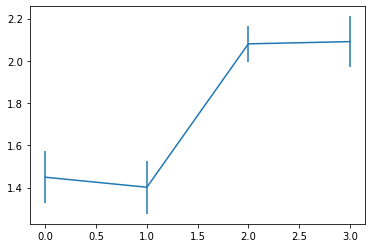

In [50]:
data = [qasvm.f(qasvm.data) for _ in range(10)]
plt.errorbar(x = list(range(4)), y=np.mean(data, axis=0), yerr=np.std(data, axis=0))